In [1]:
#################################################################
####### this needs to run on the cluster in python 2.7.6 ... ####
#################################################################
import numpy as np
import scipy as sc
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from fastcluster import linkage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z

        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))

def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)

        compute_serial_matrix transforms a distance matrix into
        a sorted distance matrix according to the order implied
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    return seriated_dist, res_order, res_linkage

In [2]:
# hit_df = pd.read_table('/scratch/lab_winter/martin/QuantSeq/MED_hit_calling_FC1.5.txt') ## this path is for cluster
hit_df = pd.read_table('S:\\lab_winter\\martin\\QuantSeq\\MED_hit_calling_FC1.5.txt') ## this is for local python
hit_df.rename_axis({'Unnamed: 0': 'geneID'}, axis="columns", inplace=True)
hit_df = hit_df[hit_df.geneID.str.startswith('ENSG')]
# condense to the 7 MEDs with hits
hit_df = hit_df.set_index('geneID', append=True)
hit_df = hit_df.iloc[:,2:-1]
# keep only genes which are hits in at least one condition
hit_df = hit_df[hit_df.any(axis=1)].astype(int)
hit_df = hit_df.reset_index(level=0, drop=True)
hit_df = hit_df.reset_index().set_index('geneID', append=True)

#test_df = pd.DataFrame({'condition_1':[1,0,1,0,1,0,0,0,1,0,1], 'condition_2':[1,0,0,0,1,0,0,0,1,1,0], 'condition_3':[1,1,1,1,0,1,1,0,0,0,1], 'condition_4':[0,1,1,0,1,1,1,1,0,0,1]}, index=['A','B','C','D','E','F','G','H','I','J','K'])

#hit_df = hit_df.iloc[:5500,:]

N = len(hit_df)

C:\Users\mjaeger\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
C:\Users\mjaeger\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
sys.setrecursionlimit(N) # allow enough recursions to go all the way down to singleton nodes

for metr in ["euclidean", "correlation"]:
    dist_mat = squareform(pdist(hit_df, metric=metr))

    for method in ["single","average","complete", "weighted"]:
        ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,method)
        #hit_df.reindex(res_order, level=0).to_excel('/scratch/lab_winter/martin/QuantSeq/heatmap_{0}_{1}.xlsx'.format(metr, method))

sys.setrecursionlimit(1000) # back to default!

In [ ]:
###########################################
####### now plot locally in ipython... ####
###########################################

plots_dir = 'W:\\lab_winter\\private\\Experiments\\Matthias_MB\\2018\\MB18_56 QuantSeq merge analysis\\plots\\clustering_for_circos\\' # directory for output plots

for metr in ["euclidean", "correlation"]:
    for method in ["single","average","complete", "weighted"]:
        scratch_df = pd.read_excel('S:\\lab_winter\\martin\\QuantSeq\\heatmap_{0}_{1}.xlsx'.format(metr, method))
        scratch_df = scratch_df.set_index('geneID', append=True)
        sns.clustermap(scratch_df, row_cluster=False)
        plt.title(method)
        plt.show()
        #plt.savefig(plots_dir + 'heatmap_correlation_{0}.pdf'.format(method), dpi=300)
        #plt.savefig(plots_dir + 'heatmap_correlation_{0}.png'.format(method), dpi=300)

In [ ]:
"""
winner clustering methods are:
    1) AVERAGE linkage with EUCLIDEAN distance!
    2) AVERAGE linkage with CORRELATION distance!
    3) WEIGHTED linkage with CORRELATION distance!

Try plotting all of the above with bioCircos!
"""

In [ ]:
for method in ["single","average","complete", "weighted", "ward"]:  # when distance = euclidean, method can also be "ward"
    for metric in ["correlation", "euclidean"]:
        if os.path.exists('S:\\lab_winter\\martin\\QuantSeq\\heatmap_{0}_{1}.xlsx'.format(metric,method)):
            rawdata = pd.read_excel('S:\\lab_winter\\martin\\QuantSeq\\heatmap_{0}_{1}.xlsx'.format(metric,method))
            # sort so that lowest to plot is first
            rawdata = rawdata.reindex(columns=['geneID', 'MED6', 'MED12', 'MED31', 'MED26', 'MED28', 'MED10', 'MED14'])
            # write as tsv so that it's easily read by R as data.frame
            #rawdata.to_csv('S:\\lab_winter\\martin\\QuantSeq\\heatmap_{0}_{1}.txt'.format(metric,method), sep="\t")

In [13]:
##### utility code:
#
# use to grep MYC from index
for metric in ["correlation", "euclidean"]:
    for method in ["single","average","complete", "weighted"]:
        scratch_df = pd.read_excel('S:\\lab_winter\\martin\\QuantSeq\\heatmap_{0}_{1}.xlsx'.format(metric, method))
        scratch_df = scratch_df.set_index('geneID', append=True)
        new = scratch_df.reset_index()
        print metric, method, "\t", new[new.geneID.str.contains('ENSG00000136997')] # use to grep MYC from index

correlation single 	      level_0           geneID  Unnamed: 0  MED10  MED12  MED14  MED26  MED28  \
5835     5835  ENSG00000136997        2762      1      0      1      0      1   

      MED31  MED6  
5835      0     0  
correlation average 	     level_0           geneID  Unnamed: 0  MED10  MED12  MED14  MED26  MED28  \
272      272  ENSG00000136997        2762      1      0      1      0      1   

     MED31  MED6  
272      0     0  
correlation complete 	      level_0           geneID  Unnamed: 0  MED10  MED12  MED14  MED26  MED28  \
5830     5830  ENSG00000136997        2762      1      0      1      0      1   

      MED31  MED6  
5830      0     0  
correlation weighted 	     level_0           geneID  Unnamed: 0  MED10  MED12  MED14  MED26  MED28  \
141      141  ENSG00000136997        2762      1      0      1      0      1   

     MED31  MED6  
141      0     0  
euclidean single 	     level_0           geneID  Unnamed: 0  MED10  MED12  MED14  MED26  MED28  \
209      209 

In [58]:
hit_df.loc[4595,:]

,MED10,MED12,MED14,MED26,MED28,MED31,MED6
geneID,,,,,,,
ENSG00000174197,1,0,1,0,0,1,0


['61', '4216', '5668', '5899', '5864', '5859', '5841', '5803', '5795', '5770', '5703', '5640', '5616', '5601', '5548', '5513', '5448', '5374', '5310', '5271', '5202', '5196', '5178', '5094', '5073', '5054', '4976', '4958', '4908', '4756', '4743', '4697', '4663', '4655', '4631', '4566', '4552', '4519', '4499', '4440', '4437', '4434', '4430', '4413', '4293', '4239', '4219', '4149', '4125', '4029', '3985', '3742', '3659', '3477', '3454', '3385', '3205', '3204', '3140', '3057', '3048', '2879', '2854', '2844', '2722', '2625', '2619', '2616', '2613', '2584', '2540', '(35)', '3208', '2336', '1148', '1957', '5069', '4861', '4595', '3736', '3648', '3316', '2645', '2469', '1616', '1254', '1335', '5537', '4978', '4809', '4649', '3277', '2061', '1996', '1295', '1249', '871', '877', '672', '4859', '5117', '5718', '3374', '4589', '5300', '4864', '3173', '1483', '126', '1417', '5290', '4723', '4077', '3777', '3613', '3331', '2872', '2299', '2118', '148', '1807', '3508', '5867', '5729', '5496', '5261'

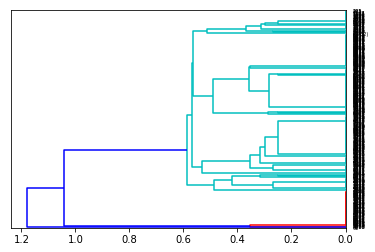

In [54]:
##### very basic clusterin to show the dendrogram => this didn't work on hit_df because the dataset was too large (recursion limit reached), when not using "truncate_mode"...
sch = sc.cluster.hierarchy

X = hit_df.values
L = sch.linkage(X, method="average", metric='correlation')
Z = sch.dendrogram(L, p=70, truncate_mode='level', orientation="left")
print Z['ivl']
plt.show(Z)

In [6]:
hit_df['rowSum'] = hit_df.sum(axis=1)

In [12]:
hit_df.to_excel('')

,,MED10,MED12,MED14,MED26,MED28,MED31,MED6,rowSum
,geneID,,,,,,,,
148,ENSG00000020633,1,0,1,0,1,0,1,4
355,ENSG00000065183,1,1,1,0,1,0,0,4
672,ENSG00000086730,1,0,1,1,1,1,0,5
994,ENSG00000101361,1,1,1,0,1,0,0,4
1187,ENSG00000104903,1,0,1,0,0,1,1,4
1224,ENSG00000105447,1,1,1,0,1,0,0,4
1807,ENSG00000116815,1,0,1,0,1,0,1,4
1856,ENSG00000117877,1,1,1,0,1,0,0,4
1870,ENSG00000118513,1,1,1,0,1,0,0,4
